In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import pickle
import warnings
import pingouin as pg
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [2]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')
ts_df = ts_df.groupby(['words','year','property'])[['count','outputs_z']].mean().reset_index()
ts_df['property_z'] = ts_df['outputs_z']


In [3]:
category_norms = pd.read_csv('./data/Referential version_Item level data.csv')
category_norms = category_norms.loc[category_norms['prod.freq'] > 1]
disease_members = category_norms.loc[category_norms.category == 'disease']['category.member'].unique()


epi_df = pd.read_csv('./data/moralization_terms/epidemics.csv') #wikipedia
epidemic_cues = []
for i, row in epi_df.iterrows():
    row_terms = row['Terms'].split(',')
    new_rows = [s.lower().strip() for s in row_terms]
    epidemic_cues += new_rows

disease_df = pd.read_csv('./data/moralization_terms/diseases.csv') #wikipedia
disease_cues = []
for i, row in disease_df.iterrows():
    row_terms = row['Terms'].split(',')
    new_rows = [s.lower().strip() for s in row_terms]
    disease_cues += new_rows
all_cues = set(epidemic_cues + disease_cues + list(disease_members))
all_cues.remove('cold')
disease_ts_df = ts_df.loc[(ts_df.words.isin(all_cues)) & (ts_df['count'] >= 50)].reset_index(drop = True)
mean_relevances = disease_ts_df.loc[(disease_ts_df.property == 'previous_link')]
mean_relevances = mean_relevances.groupby(['words','year']).outputs_z.mean().reset_index()
moral_polarities =  disease_ts_df.loc[(disease_ts_df.property == 'polarity')]
moral_polarities = moral_polarities.groupby(['words','year']).outputs_z.mean().reset_index()

all_df = ts_df.loc[(ts_df['count'] >= 50) & (~ts_df.words.isin(all_cues)) & (ts_df.property == 'previous_link')].\
groupby(['words','year']).outputs_z.mean().reset_index()
all_polarity_df = ts_df.loc[(ts_df['count'] >= 50) & (~ts_df.words.isin(all_cues)) & (ts_df.property == 'polarity')].\
groupby(['words','year']).outputs_z.mean().reset_index()

In [4]:
#disease terms:

print(all_cues)

{'salmonella', 'polio', 'baylisascariasis', 'lockjaw', 'hantaviruses', 'black fungi', 'chickenpox', 'asian flu', 'spanish flu', 'qfever', 'raccoon roundworm', 'hiv', 'kalaazar', 'dengue fever', 'malaria', 'tb', 'yellow fever', 'rabies', 'measles', 'scarlet fever', 'typhus', 'glanders', 'coronavirus', 'leukemia', 'bubonic plague', 'aids', 'black fever', 'hepatitis', 'meningitis', 'smallpox', 'trypanosomiasis', 'dengue', 'typhoid', 'cholera', 'lujo virus', 'heart disease', 'tumour', 'cryptococcosis', 'septicemic plague', 'granulomatous amoebic', 'sleepy sickness', 'marburg', 'pneumonic plague', 'leptospirosis', 'whooping cough', 'hfmd', 'tuberculosis', 'anthrax', 'meningoencephalitis', 'black fungus', 'mers', 'gae', 'triple e', 'marburg virus', 'malta fever', 'rift fever', 'rubella', 'tularemia', 'enterovirus', 'measle', 'flu', 'poliovirus', 'legionnaires', 'influenza', 'lassa fever', 'parrot fever', 'cow disease', 'ebola', 'std', 'chlamydia', 'cancer', 'aspergillosis', 'encephalitis let

In [5]:
len(mean_relevances.words.unique()) #22 disease terms in total

22

In [6]:
mean_relevances.sample(4) #(disease, year, moral relevance)

,words,year,outputs_z
97,polio,1990,1.191766
118,tuberculosis,1950,2.325789
23,cholera,1990,1.970073
40,flu,2000,0.792568


In [7]:
def get_mean_values(all_df, mean_relevances, year_column):
    B = 1000
    mean_values = []
    all_df = all_df.copy(deep = True)
    all_df.set_index('year',inplace = True)
    
    for b in range(B):
        all_dfs = []
        if b % 100 == 0:
            print(b)
        new_df = pd.DataFrame()
        for i, row in mean_relevances.iterrows():
            year = row[year_column]
            new_row = all_df.loc[all_df.index == year]
            if len(new_row) > 0:
                all_dfs.append(new_row.sample(1))
        new_df = pd.concat(all_dfs,ignore_index = True)
        mean_values.append(new_df.outputs_z.mean())
    return mean_values,new_df


In [8]:
disease_random_mean_values,disease_random_df = get_mean_values(all_df, mean_relevances,'year')

0
100
200
300
400
500
600
700
800
900


In [9]:
print(pg.ttest(disease_random_mean_values, 
                        mean_relevances.outputs_z.mean(),
                 alternative = 'less')) #diseases are more relevant than random terms

                 T  dof alternative  p-val          CI95%    cohen-d BF10  \
T-test -660.432692  999        less    0.0  [-inf, -0.02]  20.884715  inf   

        power  
T-test    1.0  


In [10]:
disease_random_mean_polarity_values,disease_polarity_random_df = get_mean_values(all_polarity_df, moral_polarities,'year')

0
100
200
300
400
500
600
700
800
900


In [11]:
print(pg.ttest(disease_random_mean_polarity_values, 
                       moral_polarities.outputs_z.mean(),
                 alternative = 'greater')) #diseases are more morally negative than random terms

                 T  dof alternative  p-val        CI95%    cohen-d BF10  power
T-test  953.753303  999     greater    0.0  [0.02, inf]  30.160328  inf    1.0


In [12]:
leader_data = pd.read_csv('./data/wikipedia_political_ts_df.csv') #political leaders

In [13]:
import os
decades = np.arange(1850 ,2010, 10)
baby_names = set()
for decade in decades:
    
    years = np.arange(decade, decade + 10)
    for year in years:
        file_dir = f'./data/names/yob{year}.txt'  #Data set of baby names in the United States. (Download seperately)
        if os.path.exists(file_dir):
            with open(file_dir) as f:
                lines = f.readlines()
                for line in lines:
                    name, gender, count = line.split(',')
                    count = int(count)
                    name = name.lower()
                    baby_names.add(name)
baby_ts_df = ts_df.loc[(ts_df['count'] >= 50) &(ts_df.property == 'previous_link') & (ts_df.words.isin(baby_names))]
baby_ts_df_polarity = ts_df.loc[(ts_df['count'] >= 50) &(ts_df.property == 'polarity') & (ts_df.words.isin(baby_names))]

In [14]:

politic_mean_relevances = leader_data.groupby(['Query','Decade']).\
Moral_relevance.mean().reset_index()
politic_mean_relevances['outputs_z'] = politic_mean_relevances.Moral_relevance

In [15]:

politic_mean_polarities = leader_data.groupby(['Query','Decade']).\
Moral_polarity.mean().reset_index()
politic_mean_polarities['outputs_z'] = politic_mean_polarities.Moral_polarity

In [16]:
print(len(politic_mean_relevances))
politic_mean_relevances

65


,Query,Decade,Moral_relevance,outputs_z
0,Abraham Lincoln,1860,1.408266,1.408266
1,Adolf Hitler,1940,2.084618,2.084618
2,Ahmed Sékou Touré,1980,-0.163273,-0.163273
3,Andrew Johnson,1860,1.128079,1.128079
4,Benito Mussolini,1940,0.331907,0.331907
...,...,...,...,...
60,William McKinley,1900,0.489170,0.489170
61,Winston Churchill,1940,0.729539,0.729539
62,Woodrow Wilson,1920,0.897606,0.897606
63,Yuri Andropov,1980,-0.924460,-0.924460


In [17]:
random_name_mean_values,random_name_df = get_mean_values(baby_ts_df,politic_mean_relevances,'Decade')

0


100
200
300
400
500
600
700
800
900


In [18]:
np.mean(random_name_mean_values), politic_mean_relevances.Moral_relevance.mean()


(-0.05163440619252994, 0.723120906675386)

In [ ]:
pg.ttest(random_name_mean_values, 
                        politic_mean_relevances.Moral_relevance.mean(), alternative = 'less') #political leaders are more morally relevant than random names

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-210.953294,999,less,0.0,"[-inf, -0.05]",6.670929,inf,1.0


In [21]:
random_name_polarity_values,random_polarity_name_df = get_mean_values(baby_ts_df_polarity,politic_mean_polarities,'Decade')

0
100
200
300
400
500
600
700
800
900


In [22]:
np.mean(random_name_polarity_values), politic_mean_polarities.Moral_polarity.mean()


(0.07185051307631082, 0.43899408802190276)

In [23]:
pg.ttest(random_name_polarity_values, 
                        politic_mean_polarities.Moral_polarity.mean(), alternative = 'less') #political leaders are more positive than random names

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-122.350159,999,less,0.0,"[-inf, 0.08]",3.869052,inf,1.0


-0.18767334286321216 0.147646685291603
                 T  dof alternative  p-val          CI95%    cohen-d BF10  \
T-test -660.432692  999        less    0.0  [-inf, -0.02]  20.884715  inf   

        power  
T-test    1.0  
Effect size: 2.401054340464371
Two group t-test:                 T  dof alternative         p-val        CI95%   cohen-d  \
T-test  20.555335  134     greater  1.459058e-43  [1.67, inf]  2.401054   

             BF10  power  
T-test  1.486e+40    1.0  
--------
-0.28379632849650704 0.18052751611144716
TtestResult(statistic=-210.95329428411506, pvalue=0.0, df=999)
Effect size: 0.9276352160080404
Two group t-test:                T  dof alternative         p-val        CI95%   cohen-d  \
T-test  5.666262   64     greater  1.868949e-07  [0.54, inf]  0.927635   

             BF10  power  
T-test  7.822e+04    1.0  
                 T  dof alternative  p-val          CI95%   cohen-d BF10  \
T-test -210.953294  999        less    0.0  [-inf, -0.05]  6.670929  inf   

 

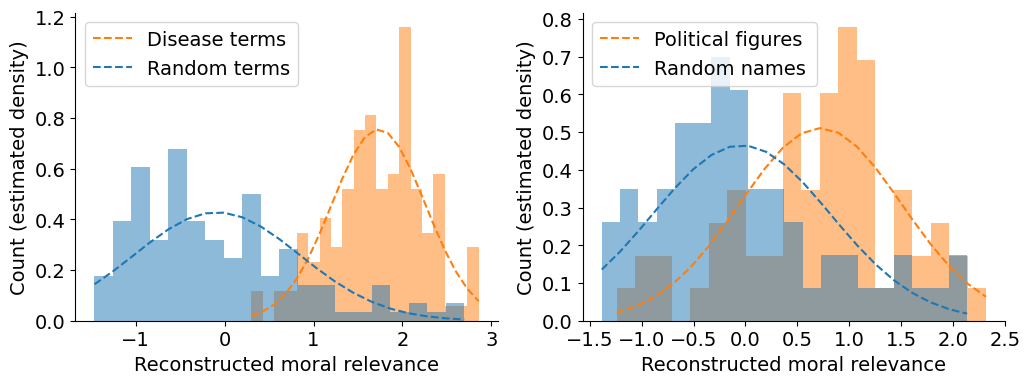

In [24]:
fig, axes = plt.subplots(1,2, figsize = (12, 4))
ax = axes[0]
std = np.std(disease_random_mean_values)
mu = np.mean(disease_random_mean_values)
print(mu - 2 * std, mu + 2 * std)

print(pg.ttest(disease_random_mean_values, 
                        mean_relevances.outputs_z.mean(),
                 alternative = 'less'))
print('Effect size:', pg.compute_effsize(mean_relevances.outputs_z, 
                          disease_random_df.outputs_z, paired=True, eftype='cohen'))

print('Two group t-test:', pg.ttest(mean_relevances.outputs_z, 
                          disease_random_df.outputs_z, paired=True,alternative = 'greater'))
z_score = (mean_relevances.outputs_z.mean() - mu) /std
# print('Zscore:', z_score, 1 - stats.norm.cdf(z_score))
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 42
std = mean_relevances.outputs_z.std()
mu = mean_relevances.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 20
n, bins, patches = ax.hist(mean_relevances.outputs_z, num_bins, density=True, color = 'tab:orange',alpha = 0.5)

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'tab:orange',label = 'Disease terms')
ax.set_ylabel('Count (estimated density)',fontsize = 14)

std = disease_random_df.outputs_z.std()
mu = disease_random_df.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)
num_bins = 20
n, bins, patches = ax.hist(disease_random_df.outputs_z, num_bins, density=True, color = 'tab:blue',alpha = 0.5)

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'tab:blue',label = 'Random terms')

ax.legend(fontsize = 14)
ax.set_xlabel(r'Reconstructed moral relevance',fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)


ax = axes[1]
print('--------')
std = np.std(random_name_mean_values)
mu = np.mean(random_name_mean_values)
print(mu - 2 * std, mu + 2 * std)
print(stats.ttest_1samp(random_name_mean_values, 
                        popmean= politic_mean_relevances.Moral_relevance.mean(), alternative = 'less'))
z_score = (politic_mean_relevances.Moral_relevance.mean() - mu) /std

print('Effect size:', pg.compute_effsize(politic_mean_relevances.Moral_relevance, 
                          random_name_df.outputs_z, paired=True, eftype='cohen'))

print('Two group t-test:', pg.ttest(politic_mean_relevances.outputs_z, 
                          random_name_df.outputs_z, paired=True,alternative = 'greater'))

z_score = (politic_mean_relevances.Moral_relevance.mean() - mu) /std
print(pg.ttest(random_name_mean_values, 
                        politic_mean_relevances.outputs_z.mean(),
                 alternative = 'less'))


rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 42


std = politic_mean_relevances.Moral_relevance.std()
mu = politic_mean_relevances.Moral_relevance.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)

num_bins = 20
n, bins, patches = ax.hist(politic_mean_relevances.Moral_relevance, num_bins, density=True, color = 'tab:orange',alpha = 0.5)

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'tab:orange',label = 'Political figures ')
ax.set_ylabel('Count (estimated density)',fontsize = 14)
std = random_name_df.outputs_z.std()
mu = random_name_df.outputs_z.mean()
rng = np.random.default_rng(19680801)
X = rng.normal(loc=mu, scale=std, size=420)
num_bins = 20
n, bins, patches = ax.hist(random_name_df.outputs_z, num_bins, density=True, color = 'tab:blue',alpha = 0.5)

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'tab:blue',label = 'Random names')
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

plt.legend(fontsize = 14)
ax.set_xlabel(r'Reconstructed moral relevance',fontsize = 14)

sns.despine()

# plt.savefig('figs/coha_2b.png', dpi = 400, bbox_inches = 'tight')
# plt.savefig('figs/coha_2b.pdf', dpi = 400, bbox_inches = 'tight')


In [25]:
len(mean_relevances.words.unique())

22

In [26]:
len(politic_mean_relevances.Query.unique())

61

In [27]:
mean_relevances['Query'] = mean_relevances.words
mean_relevances['Moral_relevance'] = mean_relevances.outputs_z
mean_relevances['Decade'] = mean_relevances.year
mean_relevances['Category'] = ['Disease'] * len(mean_relevances)
politic_mean_relevances['Category'] = ['Political figure'] * len(politic_mean_relevances)

joint_df = pd.concat((mean_relevances, politic_mean_relevances), ignore_index = True)
joint_df = joint_df.groupby(['Query','Category']).Moral_relevance.mean().reset_index()

In [28]:
from adjustText import adjust_text


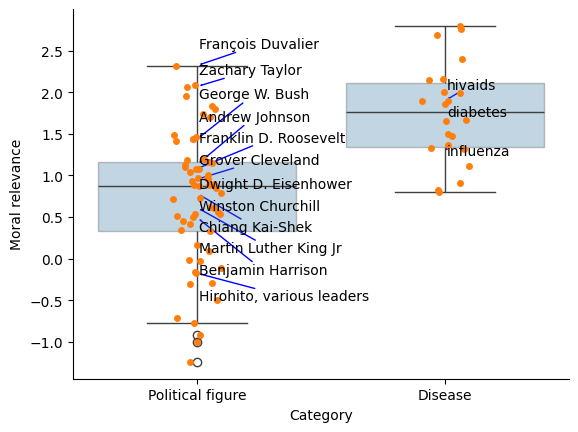

In [29]:
sns.boxplot(data = joint_df, x = 'Category', y = 'Moral_relevance',boxprops={'alpha': 0.3})
g = sns.stripplot(data = joint_df, x = 'Category', y = 'Moral_relevance')
annotations = []
for i, row in joint_df.iterrows():
    rn = np.random.random()
    
    x = 0 if row['Category'] == 'Political figure' else 1
    y = row['Moral_relevance']
    if rn <= 0.2 or x == 1 and rn <= 0.3:
        # g.text(x = x, y = y, s = row['Query'])
        annotations.append(g.annotate(row['Query'], (x, y),
                    color = 'black'))

    
adjust_text(annotations,expand=(1, 1.5),arrowprops=dict(arrowstyle='->', color='blue'))

g.set_ylabel('Moral relevance')

sns.despine()